In [ ]:
%load_ext autoreload
%autoreload 2

# PriorVAE: testing MMD (and in general different loss functions)

For a 1D GP

In [1]:
from jax import random
import jax.numpy as jnp

import time
import dill
from flax import serialization

# Numpyro
import numpyro
from numpyro.infer import MCMC, NUTS, init_to_median, Predictive


In [ ]:
numpyro.set_host_device_count(3)

In [2]:
path = "./learnt_models/04_args.dill"

with open(path, "rb") as f:
    args = dill.load(f)

args["pretrained_vae"] = True

No GPU/TPU found, falling back to CPU. (Set TF_CPP_MIN_LOG_LEVEL=0 and rerun for more info.)


## SVI to learn VAE parameters

In [3]:
import optax
import jax

from reusable.vae import vae_sample
from flax.core.frozen_dict import freeze
from functools import partial

from reusable.mmd import mmd

@jax.jit
def RCL(y, reconstructed_y, mean, log_sd):
    """reconstruction loss, averaged over the datapoints (not summed)"""
    return  jnp.sum(optax.l2_loss(reconstructed_y, y)) # 1/y.shape[0] *

@jax.jit
def KLD(y, reconstructed_y, mean, log_sd):
    """KL divergence between the distribution N(mean, log_sd) and a standard normal.
    e.g. see https://en.wikipedia.org/wiki/Kullback%E2%80%93Leibler_divergence#Multivariate_normal_distributions"""
    return -0.5 * jnp.sum(1 + log_sd - jnp.power(mean, 2) - jnp.exp(log_sd))

@jax.jit
def MMD(y, reconstructed_y, mean, log_sd):
    return mmd(y, reconstructed_y, args["mmd_kernel"])

@jax.jit
def rcl_kld(*args):
    return RCL(*args) + KLD(*args)

@jax.jit
def rcl_kld_50mmd(*args):
    return RCL(*args) + KLD(*args) + 50* MMD(*args)

@jax.jit
def kld_50mmd(*args):
    return 50* MMD(*args) + KLD(*args)


def compute_epoch_metrics(final_state: SimpleTrainState, test_samples, train_samples, train_output, test_output):

    current_metric_key = jax.random.fold_in(key=final_state.key, data=2 * final_state.step + 1)

    vae_draws = Predictive(vae_sample, num_samples=args["batch_size"])(
        current_metric_key,
        hidden_dim1=args["hidden_dim1"],
        hidden_dim2=args["hidden_dim2"],
        latent_dim=args["latent_dim"],
        out_dim=args["n"],
        decoder_params=freeze({"params": final_state.params["VAE_Decoder_0"]}),
    )["f"]

    metrics = {
        "train_mmd": mmd(vae_draws, train_samples[-1], args["mmd_kernel"]),
        "test_mmd": mmd(vae_draws, test_samples[-1], args["mmd_kernel"]),
        "train_kld": KLD(*train_output),
        "test_kld": KLD(*test_output),
        "train_rcl": RCL(*train_output),
        "test_rcl": RCL(*test_output)
    }

    return metrics


NameError: name 'SimpleTrainState' is not defined

rcl_kld_50mmd


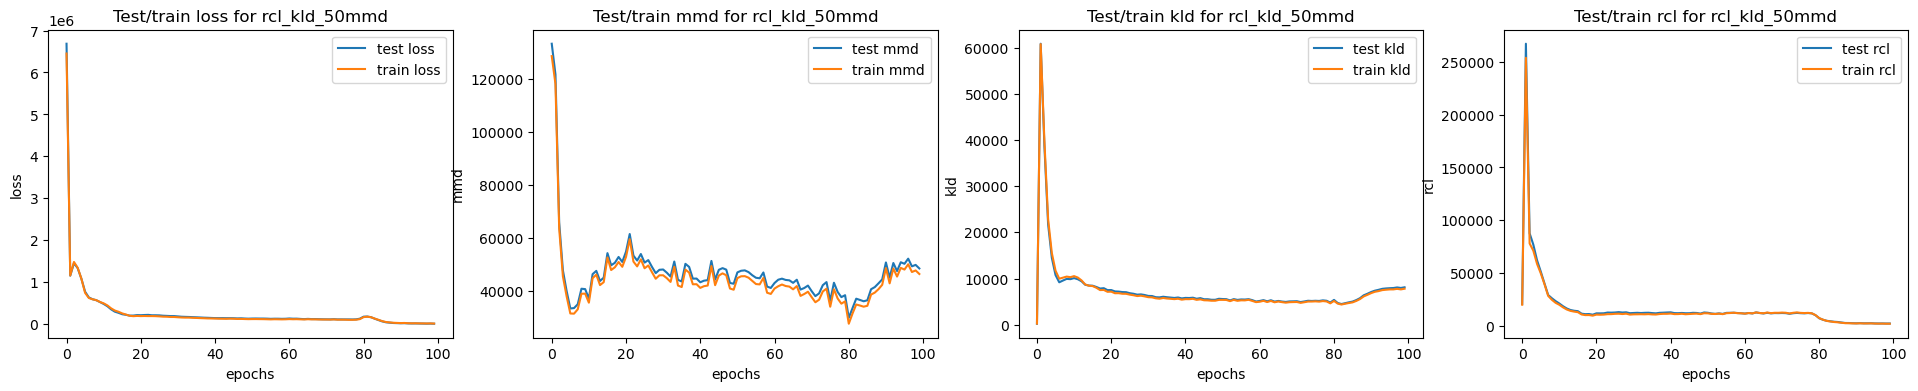

[ 1.71159962e-04 -4.83967633e-05  6.44421743e-05  7.02060861e-05
 -7.16354698e-05 -1.82289470e-04  7.49530227e-05  8.53922247e-05
  1.43317384e-05 -5.18154193e-05 -9.20718012e-05  7.33198685e-05
 -8.51511504e-05  5.50321010e-06 -1.53664922e-04 -8.22705551e-05
 -3.57020544e-05  7.21728502e-05  7.17244548e-05 -1.00549078e-04
 -2.29818179e-05 -6.11203432e-05  1.71195032e-04  1.63251651e-04
  3.74568444e-05 -6.60048390e-05 -2.50552603e-07  2.25963086e-04
  3.04446839e-05 -1.37830415e-04  1.43362158e-05 -6.21230720e-05
 -7.40199102e-05  1.76822195e-05 -1.57764531e-04  2.06231402e-04
  4.44242105e-05 -1.21499666e-04 -2.95342354e-04  1.38582604e-04
 -3.48698777e-05 -1.54512498e-04  2.47829623e-04 -2.07351713e-05
  2.14014901e-04 -1.26865387e-04  2.73502606e-04 -2.88094288e-05
  7.36963411e-05  8.97295758e-05 -1.67127175e-04 -4.81949828e-05
 -1.50032225e-04 -8.83859248e-05 -2.14534346e-04  1.38065850e-04
 -1.47718310e-04 -2.16731642e-04 -5.95603051e-05 -9.86362502e-05
 -2.10518774e-05 -1.84824

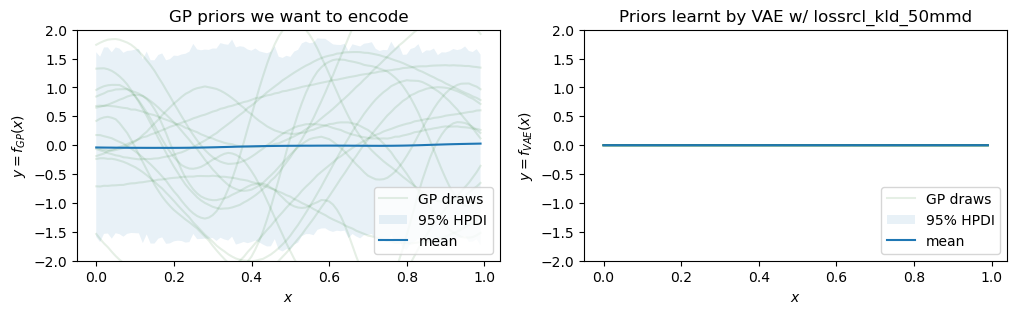

kld_50mmd


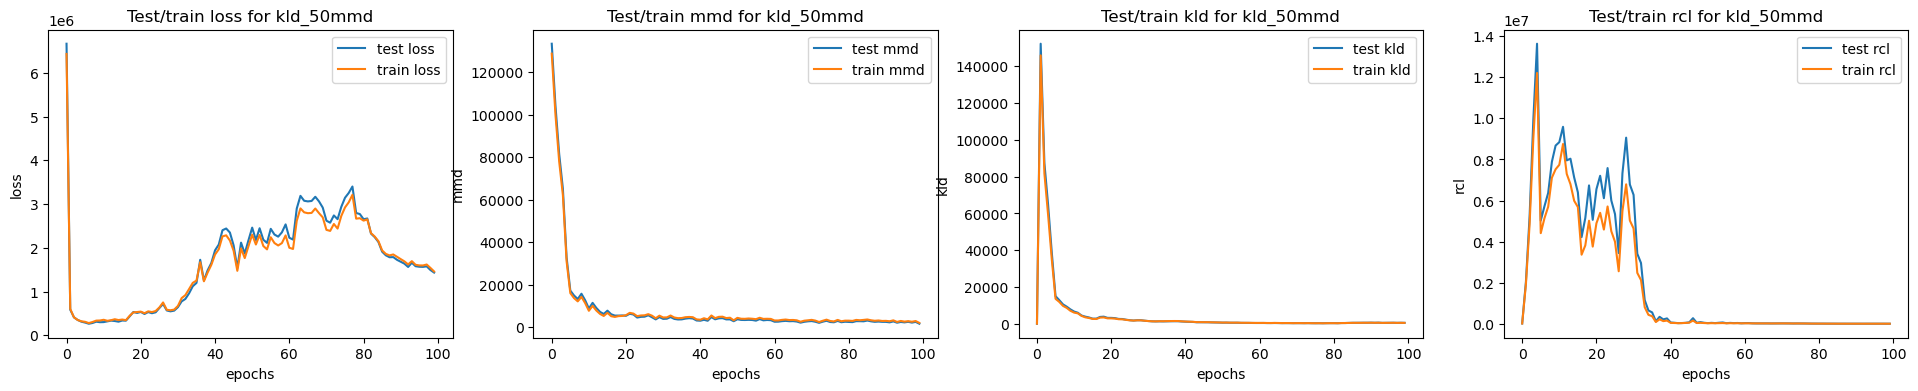

[ 1.71159962e-04 -4.83967633e-05  6.44421743e-05  7.02060861e-05
 -7.16354698e-05 -1.82289470e-04  7.49530227e-05  8.53922247e-05
  1.43317384e-05 -5.18154193e-05 -9.20718012e-05  7.33198685e-05
 -8.51511504e-05  5.50321010e-06 -1.53664922e-04 -8.22705551e-05
 -3.57020544e-05  7.21728502e-05  7.17244548e-05 -1.00549078e-04
 -2.29818179e-05 -6.11203432e-05  1.71195032e-04  1.63251651e-04
  3.74568444e-05 -6.60048390e-05 -2.50552603e-07  2.25963086e-04
  3.04446839e-05 -1.37830415e-04  1.43362158e-05 -6.21230720e-05
 -7.40199102e-05  1.76822195e-05 -1.57764531e-04  2.06231402e-04
  4.44242105e-05 -1.21499666e-04 -2.95342354e-04  1.38582604e-04
 -3.48698777e-05 -1.54512498e-04  2.47829623e-04 -2.07351713e-05
  2.14014901e-04 -1.26865387e-04  2.73502606e-04 -2.88094288e-05
  7.36963411e-05  8.97295758e-05 -1.67127175e-04 -4.81949828e-05
 -1.50032225e-04 -8.83859248e-05 -2.14534346e-04  1.38065850e-04
 -1.47718310e-04 -2.16731642e-04 -5.95603051e-05 -9.86362502e-05
 -2.10518774e-05 -1.84824

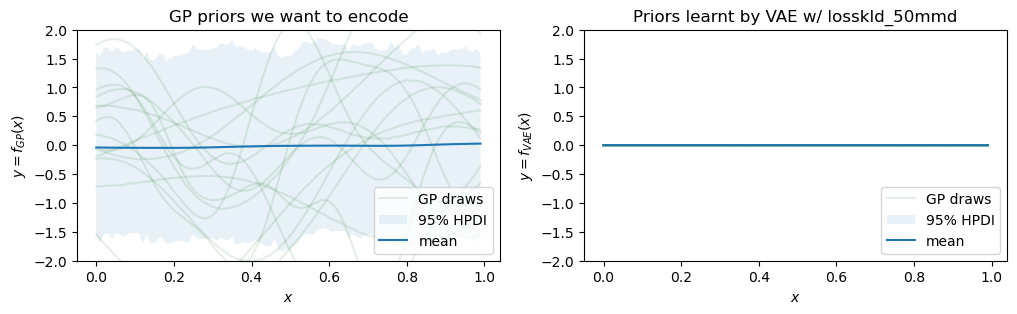

rcl_kld


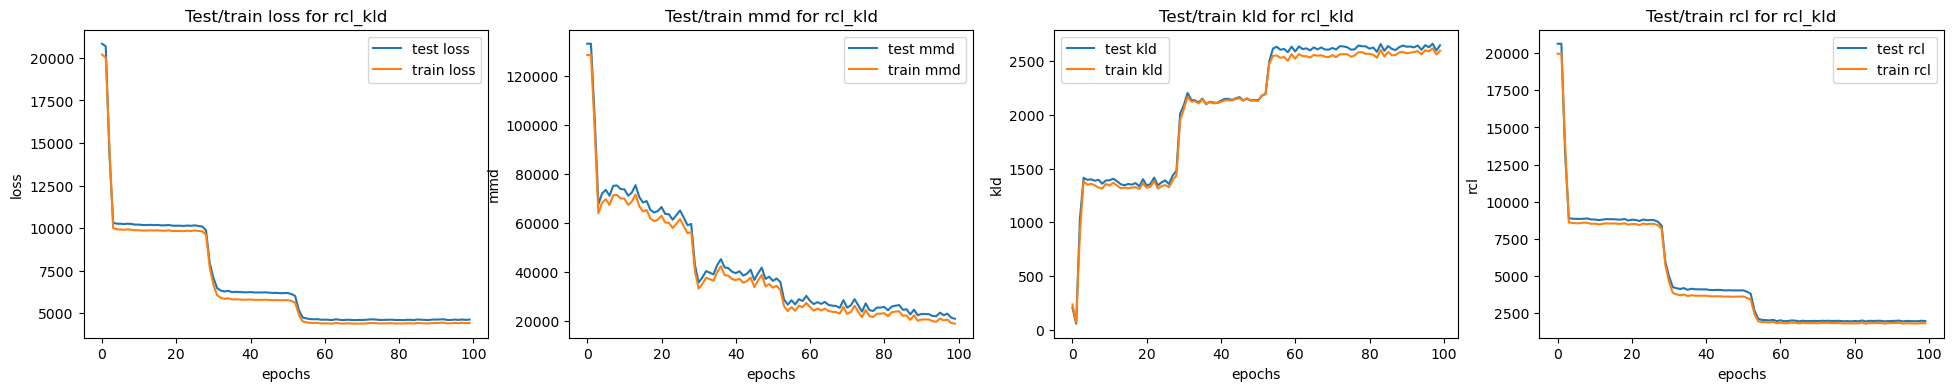

[ 1.71159962e-04 -4.83967633e-05  6.44421743e-05  7.02060861e-05
 -7.16354698e-05 -1.82289470e-04  7.49530227e-05  8.53922247e-05
  1.43317384e-05 -5.18154193e-05 -9.20718012e-05  7.33198685e-05
 -8.51511504e-05  5.50321010e-06 -1.53664922e-04 -8.22705551e-05
 -3.57020544e-05  7.21728502e-05  7.17244548e-05 -1.00549078e-04
 -2.29818179e-05 -6.11203432e-05  1.71195032e-04  1.63251651e-04
  3.74568444e-05 -6.60048390e-05 -2.50552603e-07  2.25963086e-04
  3.04446839e-05 -1.37830415e-04  1.43362158e-05 -6.21230720e-05
 -7.40199102e-05  1.76822195e-05 -1.57764531e-04  2.06231402e-04
  4.44242105e-05 -1.21499666e-04 -2.95342354e-04  1.38582604e-04
 -3.48698777e-05 -1.54512498e-04  2.47829623e-04 -2.07351713e-05
  2.14014901e-04 -1.26865387e-04  2.73502606e-04 -2.88094288e-05
  7.36963411e-05  8.97295758e-05 -1.67127175e-04 -4.81949828e-05
 -1.50032225e-04 -8.83859248e-05 -2.14534346e-04  1.38065850e-04
 -1.47718310e-04 -2.16731642e-04 -5.95603051e-05 -9.86362502e-05
 -2.10518774e-05 -1.84824

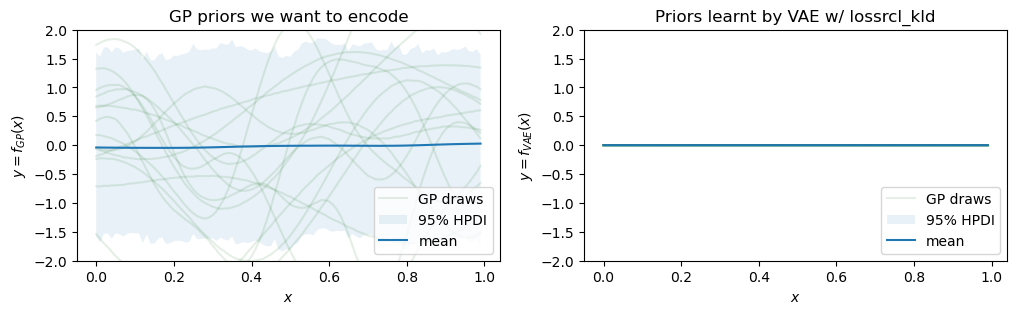

In [8]:

from reusable.util import decoder_filename, get_savepath
import matplotlib.pyplot as plt
from plotting.plots import plot_training, compare_draws

from reusable.gp import OneDGP
from reusable.vae import vae_sample

from reusable.vae import VAE_Decoder

rng_key_gp, rng_key_predict = random.split(random.PRNGKey(2))


plot_gp_predictive = Predictive(OneDGP, num_samples=1000)
gp_draws = plot_gp_predictive(rng_key_gp, x=args["x"], gp_kernel = args["gp_kernel"], jitter=1e-5)['y']


loss_fns = [rcl_kld_50mmd, kld_50mmd, rcl_kld]
for loss_fn in loss_fns:
    print( loss_fn.__name__)
    file_path = f'{get_savepath()}/{decoder_filename("04", args, suffix=loss_fn.__name__+"_metrics_hist")}'

    with open(file_path, 'rb') as file:
        metrics_history = dill.load(file)

    fig, axs = plt.subplots(nrows=1, ncols=4, figsize=(24, 4))

    for i,t in enumerate(["loss", "mmd", "kld", "rcl"]):
        
        plot_training(
            jnp.array(metrics_history["test_"+t]).flatten(),
            jnp.array(metrics_history["train_"+t]).flatten(),
            f"Test/train {t} for " + loss_fn.__name__,
            t,
            axs[i],
        )
    plt.show()

    dummy_decoder = VAE_Decoder(hidden_dim1=args["hidden_dim1"],   hidden_dim2=args["hidden_dim2"], out_dim=args["n"])
    dummy_params = dummy_decoder.init(random.PRNGKey(0), jnp.ones((args["latent_dim"],)))

    file_path = f'{get_savepath()}/{decoder_filename("04", args, suffix=loss_fn.__name__)}'

    with open(file_path, 'rb') as file:
        bytes = file.read()
        
        args["decoder_params"] = serialization.from_bytes(dummy_params, bytes)

    plot_vae_predictive = Predictive(vae_sample, num_samples=1000)
    vae_draws = plot_vae_predictive(
        rng_key_predict,
        hidden_dim1=args["hidden_dim1"],
        hidden_dim2=args["hidden_dim2"],
        latent_dim=args["latent_dim"],
        out_dim=args["n"],
        decoder_params=args["decoder_params"],
    )["f"]

    print(vae_draws[0], vae_draws[1])
    print(args["decoder_params"])
            


    compare_draws(args["x"], gp_draws, vae_draws, "GP priors we want to encode", "Priors learnt by VAE w/ loss" + loss_fn.__name__, '$y=f_{GP}(x)$', '$y=f_{VAE}(x)$', save_path="gen_plots/01_prior_comp.png")
    plt.show()

        